In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import trange
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from tqdm import trange

In [3]:
plt.rcParams['figure.figsize'] = (20,10)

# Data Understanding and Data Pre-Proccessing

In [4]:
data = pd.read_csv('EUR_USD_M30_Output_Since_2005.csv')

In [5]:
data.head(5)

,DateTime,Volume,Open,High,Low,Close
0,2005-01-02T18:00:00.000000000Z,1,1.3560,1.3560,1.3560,1.3560
1,2005-01-02T18:30:00.000000000Z,5,1.3560,1.3568,1.3560,1.3567
2,2005-01-02T19:00:00.000000000Z,32,1.3569,1.3570,1.3556,1.3556
3,2005-01-02T19:30:00.000000000Z,12,1.3556,1.3565,1.3556,1.3558
4,2005-01-02T20:00:00.000000000Z,27,1.3559,1.3561,1.3556,1.3558


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166972 entries, 0 to 166971
Data columns (total 6 columns):
DateTime    166972 non-null object
Volume      166972 non-null int64
Open        166972 non-null float64
High        166972 non-null float64
Low         166972 non-null float64
Close       166972 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.6+ MB


In [7]:
data.isnull().sum() 

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [8]:
data.isna().sum()

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [9]:
data = data.iloc[:,[0,2,5]]

In [10]:
data.DateTime = pd.to_datetime(data.DateTime)

In [11]:
data.head(5)

,DateTime,Open,Close
0,2005-01-02 18:00:00,1.3560,1.3560
1,2005-01-02 18:30:00,1.3560,1.3567
2,2005-01-02 19:00:00,1.3569,1.3556
3,2005-01-02 19:30:00,1.3556,1.3558
4,2005-01-02 20:00:00,1.3559,1.3558


In [12]:
# data['diff'] = (data.iloc[:,2] - data.iloc[:,1])

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


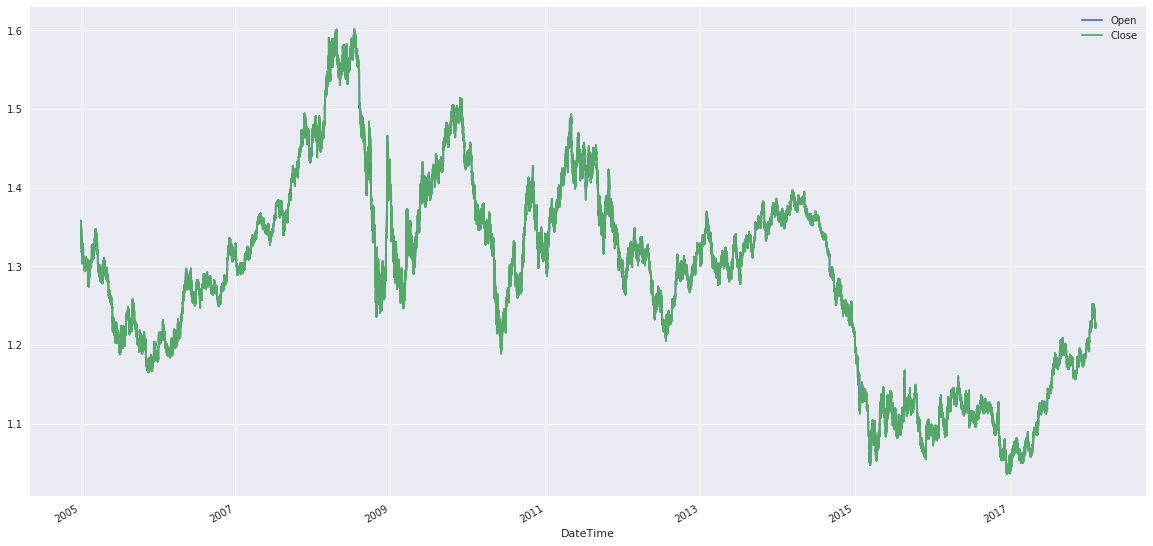

In [13]:
# plt.plot(range(len(data)) , data.iloc[: , 1])
data.plot(x='DateTime', y=['Open', 'Close'])

open and close price seem to be so close , so we would need one of them.

In [14]:
data = data.iloc[:, [0,2]]
data = data.rename(columns={'Close': 'Value'})

# calculate diffrence in default length 

*** this difference is kind of normalized in the whole project and it's gonna be used anywhere difference measurement needed***

In [15]:
def percent_change(start_p, current_p):
    try:
        x = ((current_p - start_p) / abs(start_p)) * 100
        if x == 0:
            return 1e-10
        else:
            return x
    except Exception as e:
        return 1e-10

In [16]:
percent_change(data.iloc[0,1] , data.iloc[1,1])

0.05162241887905036

In [17]:
pattern_ar = []
performance_ar = []

*** pattern finder ***

In [18]:
x = len(data) - 30
y = 11

for y in trange(11, x):
    tmp_pattern = []
    for i in range(9, -1, -1):
        tmp_pattern.append(percent_change(data.Value[y-10], data.Value[y-i]))

    current_point = data.Value[y]
    outcome_range = data.Value[y+20 : y+30]
    try:
        avrage_outcome = outcome_range.mean()
    except Exception as e:
        print(e)
        avrage_outcome = 1e-10
        
    future_outcome = percent_change(current_point, avrage_outcome)
    
    pattern_ar.append(tmp_pattern)
    performance_ar.append(future_outcome)
    
    
#     print('current :', current_point)
#     print('outcome :', avrage_outcome)
#     print('percent change outcome :', future_outcome, '%')
#     print('_______')
#     print(tmp_pattern)
#     break

pattern_ar = np.array(pattern_ar)
performance_ar = np.array(performance_ar)

100%|██████████| 166931/166931 [01:42<00:00, 1624.68it/s]


In [19]:
t = 35566
print(performance_ar[t])
print(pattern_ar[t])

0.36020935002475524
[-0.00705985 -0.11295765 -0.06212671 -0.15531678 -0.13272524 -0.19485195
 -0.22732728 -0.21885546 -0.24003502 -0.18073225]


In [20]:
len(performance_ar[performance_ar > 0])

83987

*** current pattern ***

In [21]:
current_pattern = []
for i in range(-10, 0):
    current_pattern.append(percent_change(data.Value.iloc[-11], data.Value.iloc[i]))
#     print(i, data.Value.iloc[i])

current_pattern = np.array(current_pattern)
print(current_pattern)

[-0.03353536 -0.09815228 -0.08915499  0.02453807  0.0229022   0.04335059
  0.06461692  0.07279628  0.1513181   0.20693773]


*** current pattern recognition ***

In [27]:
sim_pat_inx = []
for p in trange(len(pattern_ar)):
    sim = []
    for i in range(10):
        sim.append(100 - abs(percent_change(current_pattern[i], pattern_ar[p][i])))
    sim = np.array(sim)
    # max of how sim = 100
    how_sim = sim.mean()
    
#     print(sim)
#     print(how_sim)
    
    if how_sim >= 60:
        sim_pat_inx.append([p, how_sim])
print(len(sim_pat_inx), 'similar pattern found!')
print(sim_pat_inx)

100%|██████████| 166931/166931 [00:04<00:00, 35080.11it/s]

30 similar pattern found!
[[1641, 62.5862940924579], [1755, 61.593430354946705], [9539, 69.01206847855745], [23097, 61.03590348977472], [23420, 66.6954662837568], [24104, 60.4648729046222], [25659, 60.69462958579758], [31146, 61.54494096626163], [34573, 60.86678099366172], [37426, 62.44065733591365], [37714, 61.50409414638152], [38157, 60.024052660603694], [39400, 60.10395121679727], [43225, 62.94340344248801], [43624, 60.718372460652446], [61923, 64.66062308980742], [62374, 60.86770761787864], [66336, 62.22218669463755], [93033, 61.15265677688349], [97155, 63.3325395379289], [97441, 61.3101195459725], [100361, 67.57416645851733], [102639, 69.71707029300562], [105277, 63.57214297815072], [116179, 63.032993943129384], [124900, 63.315129965571046], [128207, 60.14823422643296], [153936, 74.71104917787497], [160588, 63.04938751274665], [161275, 67.36747093535922]]


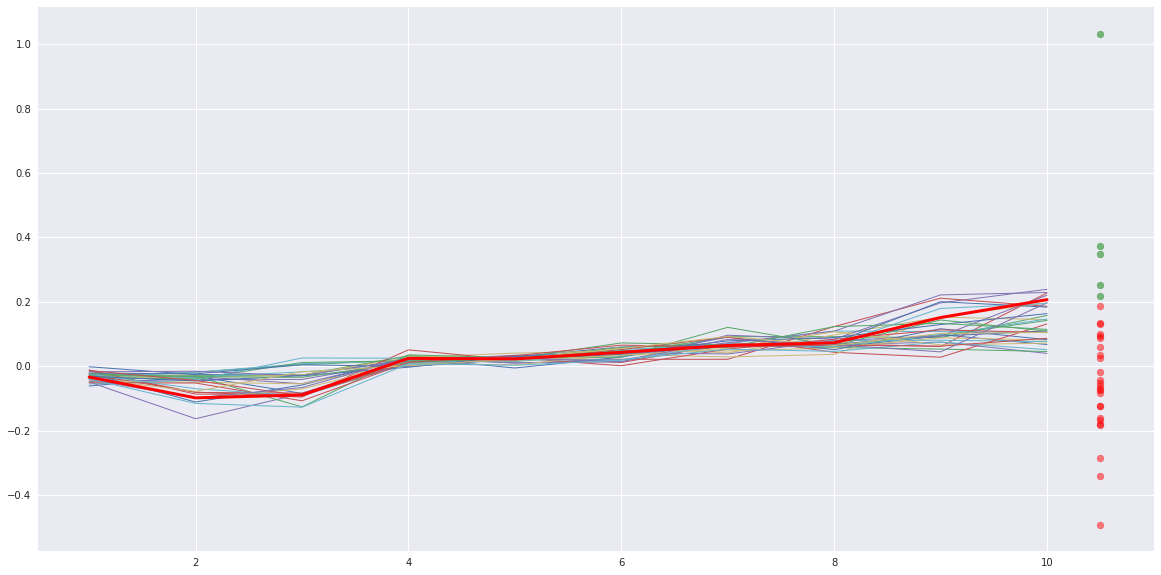

In [45]:
for i in range(len(sim_pat_inx)):
    plt.plot(range(1,11), pattern_ar[sim_pat_inx[i][0]], linewidth=1)
    
    tmp_performance = performance_ar[sim_pat_inx[i][0]]
    # if statement is because if future performance is upper than current patterns' change line
    if tmp_performance > current_pattern[-1]:
        pcolor = 'green'
    else:
        pcolor = 'red'
    plt.scatter(10.5, performance_ar[sim_pat_inx[i][0]], c=pcolor, alpha=0.5)
plt.plot(range(1,11), current_pattern, c='red', linewidth=3)
plt.show()